In [48]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style
import requests
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.dates as mdates
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Get the stock data using yahoo API:
style.use('ggplot')
ticker=input("Please enter stock name ")
# get 2014-2018 data to train our model
start_t = datetime.datetime(2014,1,1)
end_t = datetime.datetime(2018,12,30)
df = yf.download(ticker, start=start_t, end=end_t)

# get 2019 data to test our model on 
start = datetime.datetime(2019,1,1)
end = datetime.date.today()
test_df = yf.download(ticker, start=start, end=end)


Please enter stock name AAPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [50]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-21,39.215000,39.540001,37.407501,37.682499,36.581314,382978400
2018-12-24,37.037498,37.887501,36.647499,36.707500,35.634811,148676800
2018-12-26,37.075001,39.307499,36.680000,39.292500,38.144272,234330000
2018-12-27,38.959999,39.192501,37.517502,39.037498,37.896725,212468400
2018-12-28,39.375000,39.630001,38.637501,39.057499,37.916138,169165600


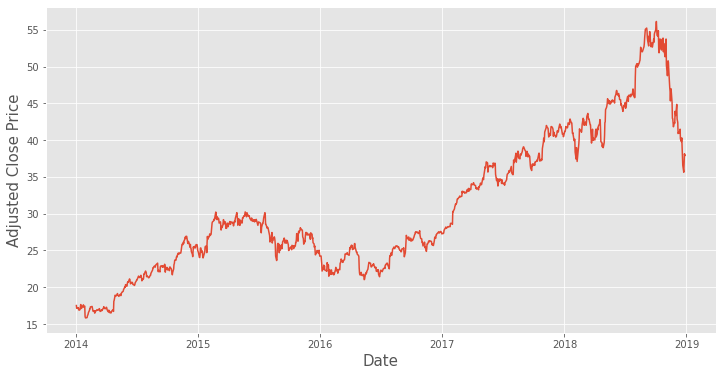

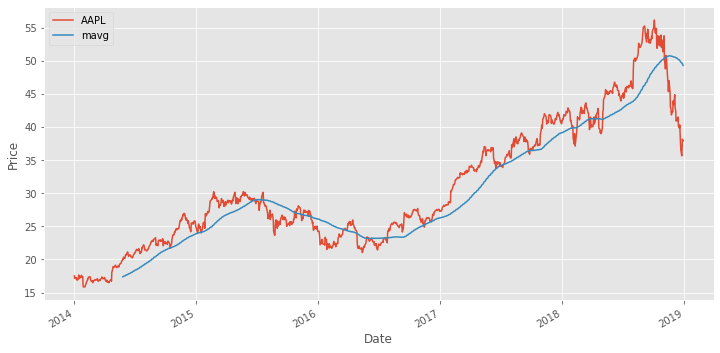

In [51]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()


# Rolling mean also called market average
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label=ticker)
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [52]:
# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,737049.0,39.215000,39.540001,37.407501,37.682499,36.581314,382978400
1253,737052.0,37.037498,37.887501,36.647499,36.707500,35.634811,148676800
1254,737054.0,37.075001,39.307499,36.680000,39.292500,38.144272,234330000
1255,737055.0,38.959999,39.192501,37.517502,39.037498,37.896725,212468400
1256,737056.0,39.375000,39.630001,38.637501,39.057499,37.916138,169165600


In [53]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].values
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1257,)


In [54]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1221, 36, 1)
X_train:
[[17.51660347]
 [17.13183594]
 [17.2252636 ]
 [17.10206604]
 [17.21038246]
 [16.99059486]
 [16.87722969]
 [16.96557617]
 [17.30316353]
 [17.65056038]
 [17.55207634]
 [17.12202072]
 [17.38803673]
 [17.46531105]
 [17.61319351]
 [17.29302788]
 [17.43331909]
 [16.0399189 ]
 [15.85783005]
 [15.82711315]
 [15.85307598]
 [15.88253307]
 [16.11244011]
 [16.23277664]
 [16.32740021]
 [16.55582047]
 [16.85240555]
 [17.07445526]
 [17.07318687]
 [17.34429932]
 [17.33027458]
 [17.39399529]
 [17.11938477]
 [16.92122841]
 [16.73326302]
 [16.80653954]]


y_train: [[16.63163757]]



In [55]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
86/86 [==============================] - 10s 70ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 2/20
86/86 [==============================] - 5s 54ms/step - loss: 9.2551e-04 - val_loss: 0.0062
Epoch 3/20
86/86 [==============================] - 5s 54ms/step - loss: 7.7747e-04 - val_loss: 0.0021
Epoch 4/20
86/86 [==============================] - 5s 58ms/step - loss: 6.9924e-04 - val_loss: 0.0020
Epoch 5/20
86/86 [==============================] - 5s 57ms/step - loss: 7.5429e-04 - val_loss: 0.0038
Epoch 6/20
86/86 [==============================] - 5s 57ms/step - loss: 5.7773e-04 - val_loss: 0.0014
Epoch 7/20
86/86 [==============================] - 5s 55ms/step - loss: 5.9166e-04 - val_loss: 0.0036
Epoch 8/20
86/86 [==============================] - 5s 57ms/step - loss: 6.0019e-04 - val_loss: 0.0024
Epoch 9/20
86/86 [==============================] - 5s 55ms/step - loss: 6.5185e-04 - val_loss: 0.0013
Epoch 10/20
86/86 [==============================] - 5s 56ms/step - loss: 5.

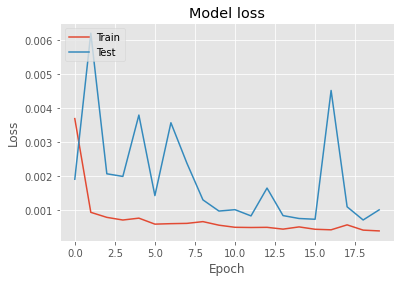

In [56]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

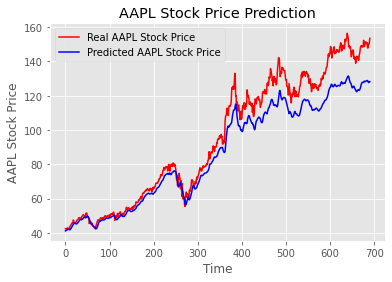

In [59]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# plot the results 
plt.plot(org_y, color = 'red', label = f'Real {ticker} Stock Price ')
plt.plot(predicted_y, color = 'blue', label = f'Predicted {ticker} Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{ticker} Stock Price')
plt.legend()
plt.show()